**Question:** what metrics other than rate can be applied to a window of spikes, that carry information independently from each other. 

**Logic:** Generate spikes trains with varying rate and varying inter-spike intervals. Apply PCA and other dimensionality reduction techniques to understand what integral components of data carry information.

**Conclusions:**

As expected, most of information due to inter-spike interval is on short time-scale and is lost due to averaging.

When there is no retardation
  * Some information is carried in rate
  * Most information carried in high frequency harmonics
  
With significant retardation
  * Most information is carried in rate
  * Exponentially less information is carried in cosine foureir series
  
PCA-Space plots show that
  * First PCA counts rate
  * Next two PCA count spikes

Next tricks to try:
  * Try to understand how variance fits into the picture. It is non-linear
  * What are the effects of noise on the metrics?
  * Compute effective rate and inter-spike interval. Attempt to predict them from signal

In [15]:
import numpy as np
import matplotlib.pyplot as plt

Total Data (600000, 20)
Total Data (300, 2000)


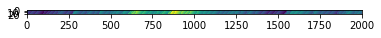

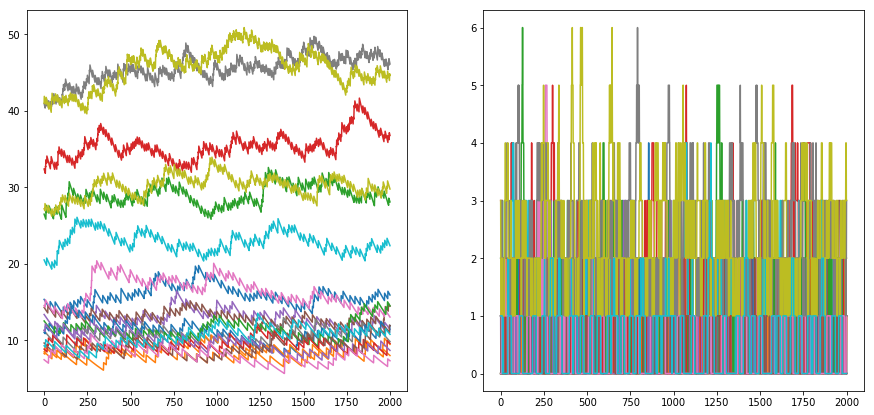

In [45]:
WINDOW_SIZE = 20 #ms
SAMPLE_SIZE = 2000 #ms
INITIAL_SKIP_WINDOWS = 1
MIN_SPIKE_INTERVAL = 1 #ms
MAX_SPIKE_INTERVAL = [10, 100]
TAUCONV = 400 #ms

def genSpikes(tauconv = 0):
    SHIFT_START = INITIAL_SKIP_WINDOWS * WINDOW_SIZE
    SHIFT_END = (INITIAL_SKIP_WINDOWS + 1) * WINDOW_SIZE
    SAMPLE_SIZE_EXT = SAMPLE_SIZE + SHIFT_END
    
    # Generate Spikes
    reztmp = np.zeros(SAMPLE_SIZE_EXT)
    MAX_INTERVAL_EFF = np.random.randint(MAX_SPIKE_INTERVAL[0],MAX_SPIKE_INTERVAL[1])
    i = np.random.randint(0, MAX_INTERVAL_EFF / 2)
    while i < SAMPLE_SIZE_EXT:
        reztmp[i] = 1
        i += np.random.randint(MIN_SPIKE_INTERVAL, MAX_INTERVAL_EFF)
    
    spikes = np.sum([reztmp[i:i-WINDOW_SIZE].copy() for i in range(WINDOW_SIZE)], axis=0)[SHIFT_START:]
    
    # Convolve with decaying exponential
    if tauconv > 0:
        # Set initial convolved rate to static convolved rate to converge faster
        SPIKE_INTERVAL_AVG = 1 + (MAX_INTERVAL_EFF + MIN_SPIKE_INTERVAL) / 2
        reztmpconv = np.zeros(SAMPLE_SIZE_EXT)
        reztmp[0] += tauconv / SPIKE_INTERVAL_AVG
        
        # Calculate convolution
        for i in range(1, SAMPLE_SIZE_EXT):
            reztmp[i] += reztmp[i-1] * np.exp(-1/tauconv)
    
    # Sample the spike set using a moving window, skipping the beginning to avoid boundary effects
    rez = np.zeros((SAMPLE_SIZE, WINDOW_SIZE))
    for i in range(0, SAMPLE_SIZE):
        rez[i] = reztmp[SHIFT_START + i: SHIFT_END + i]
        
    return rez, spikes
    

N_SAMPLE = 300
SAMPLES, SPIKES = genSpikes(TAUCONV)
for i in range(N_SAMPLE-1):
    smpl, spk = genSpikes(TAUCONV)
    SAMPLES = np.vstack((SAMPLES, smpl))
    SPIKES = np.vstack((SPIKES, spk))

print('Total Data', SAMPLES.shape)
print('Total Data', SPIKES.shape)
    
plt.figure()
plt.imshow(SAMPLES[:SAMPLE_SIZE].T)
plt.show()

fig, ax = plt.subplots(ncols = 2, figsize=(15, 7))
for i in range(20):
    ax[0].plot(SAMPLES[i*SAMPLE_SIZE:(i+1)*SAMPLE_SIZE][:,0])
    ax[1].plot(SPIKES[i])
plt.show()

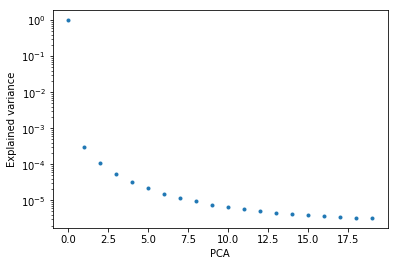

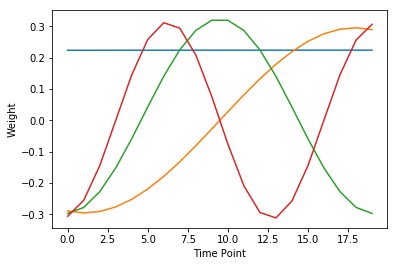

In [22]:
# Attempt to analyze data using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=WINDOW_SIZE)
pca.fit(SAMPLES)

plt.figure()
plt.semilogy(pca.explained_variance_ratio_, '.')
# plt.ylim([0, 1.1*pca.explained_variance_ratio_[0]])
plt.xlabel('PCA')
plt.ylabel('Explained variance')
plt.show()

# plt.figure()
# plt.plot(pca.singular_values_)
# plt.show()

plt.figure()
plt.plot(pca.components_[0])
plt.plot(pca.components_[1])
plt.plot(pca.components_[2])
plt.plot(pca.components_[3])
plt.xlabel('Time Point')
plt.ylabel('Weight')
plt.show()

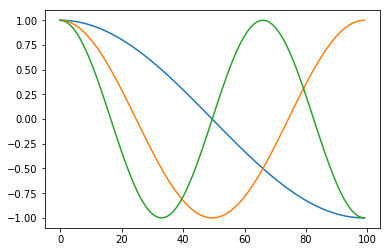

In [4]:
plt.figure()
plt.plot(np.cos(np.linspace(0, 1*np.pi, 100)))
plt.plot(np.cos(np.linspace(0, 2*np.pi, 100)))
plt.plot(np.cos(np.linspace(0, 3*np.pi, 100)))
plt.show()

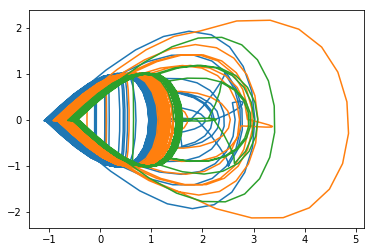

In [33]:
# Generate trajectories in PCA space

plt.figure()
for i in range(3):
    trial = SAMPLES[i*SAMPLE_SIZE : (i+1)*SAMPLE_SIZE]
    traj0 = trial.dot(pca.components_[1])
    traj1 = trial.dot(pca.components_[2])
#     plt.plot(traj0)
    plt.plot(traj0, traj1, '-')
plt.show()